In [1]:
import numpy as np
import gym
from gym import spaces
import random
import matplotlib.pyplot as plt
import optuna

In [2]:
class IntergalacticPlanetExplorer(gym.Env):
    def __init__(self):
        super(IntergalacticPlanetExplorer, self).__init__()

        self.observation_space = spaces.Discrete(25)
        self.action_space = spaces.Discrete(4)

        self.state = 0
        self.reward_table = {
            'black_hole': -20,
            'space_pirates': -15,
            'hostile_alien': -10,
            'common_resource': 5,
            'rare_resource': 10,
            'ultra_rare_resource': 15,
            'home_base': 20
        }

        self.planet_elements = {
            4: 'black_hole',
            6: 'space_pirates',
            8: 'hostile_alien',
            12: 'common_resource',
            16: 'rare_resource',
            20: 'ultra_rare_resource',
            24: 'home_base'
        }

    def step(self, action):
        if action == 0: # Up
            if self.state >= 5:
                self.state -= 5
        elif action == 1: # Down
            if self.state <= 19:
                self.state += 5
        elif action == 2: # Right
            if self.state % 5 != 4:
                self.state += 1
        elif action == 3: # Left
            if self.state % 5 != 0:
                self.state -= 1

        reward = 0
        done = False
        
        if self.state in self.planet_elements:
            element = self.planet_elements[self.state]
            reward = self.reward_table[element]

            if element == 'home_base':
                done = True

        return self.state, reward, done, {}

    def reset(self):
        self.state = 0
        return self.state

    def render(self):
        grid = np.zeros((5, 5))

        for key, value in self.planet_elements.items():
            row, col = divmod(key, 5)
            if value == 'black_hole':
                grid[row, col] = 1
            elif value == 'space_pirates':
                grid[row, col] = 2
            elif value == 'hostile_alien':
                grid[row, col] = 3
            elif value == 'common_resource':
                grid[row, col] = 4
            elif value == 'rare_resource':
                grid[row, col] = 5
            elif value == 'ultra_rare_resource':
                grid[row, col] = 6
            elif value == 'home_base':
                grid[row, col] = 7

        spaceship_row, spaceship_col = divmod(self.state, 5)
        grid[spaceship_row, spaceship_col] = 8

        fig, ax = plt.subplots()
        cmap = plt.cm.get_cmap('cubehelix', 9)
        ax.imshow(grid, cmap=cmap)

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color=cmap(1), label='Black Hole', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(2), label='Space Pirates', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(3), label='Hostile Alien', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(4), label='Common Resource', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(5), label='Rare Resource', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(6), label='Ultra-Rare Resource', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(7), label='Home Base', markersize=10),
            plt.Line2D([0], [0], marker='o', color=cmap(8), label='Spaceship', markersize=10),
        ]

        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        for i in range(5):
            for j in range(5):
                if (i, j) == (spaceship_row, spaceship_col):
                    text = 'S'
                else:
                    text = ''
                ax.text(j, i, text, ha='center', va='center', color='black')

        plt.show()

C:\Users\karti\AppData\Local\Temp\ipykernel_22608\1072394450.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cubehelix', 9)


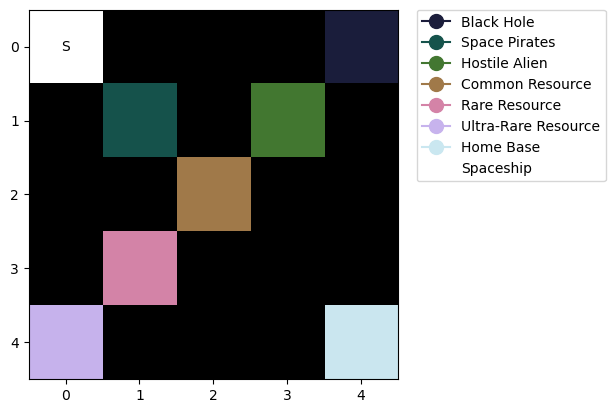

Step: 1
State: 0
Action: 3
Reward: 0
Current grid:


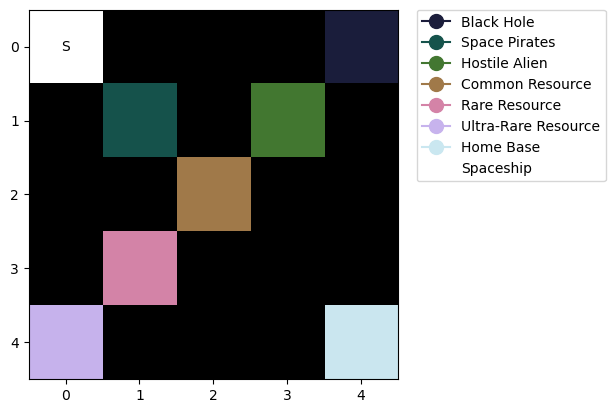


Step: 2
State: 0
Action: 3
Reward: 0
Current grid:


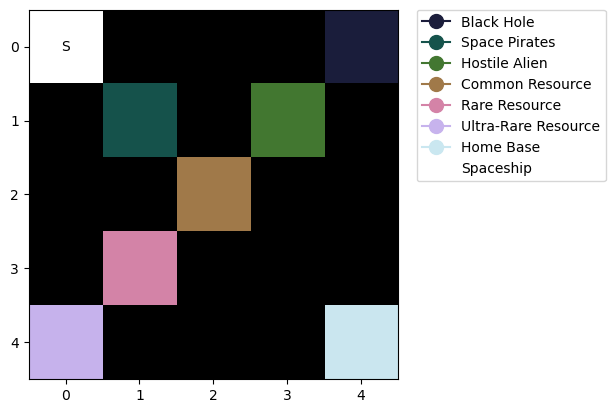


Step: 3
State: 0
Action: 0
Reward: 0
Current grid:


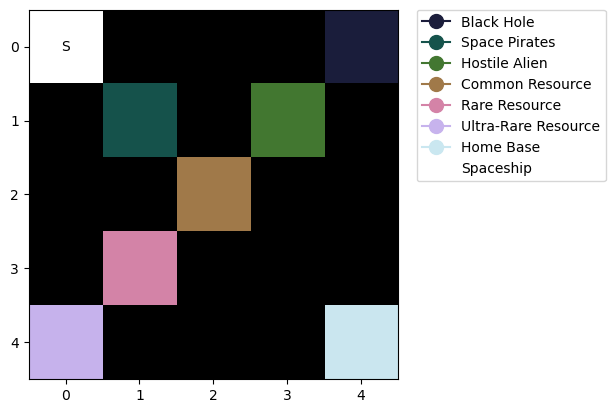


Step: 4
State: 1
Action: 2
Reward: 0
Current grid:


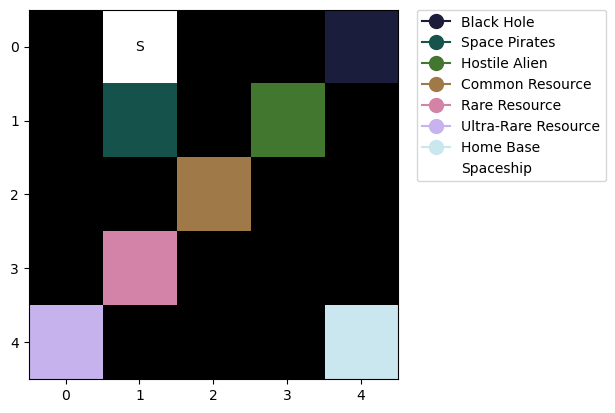


Step: 5
State: 6
Action: 1
Reward: -15
Current grid:


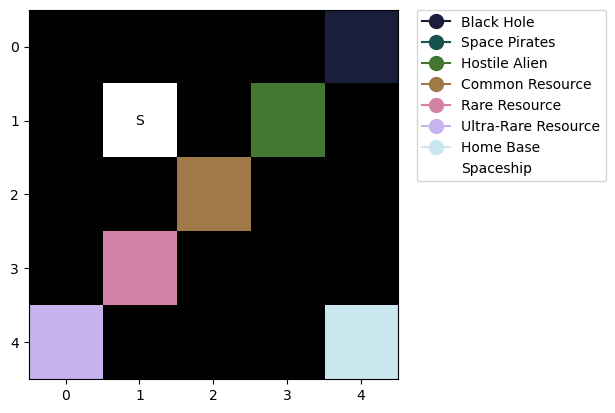


Step: 6
State: 5
Action: 3
Reward: 0
Current grid:


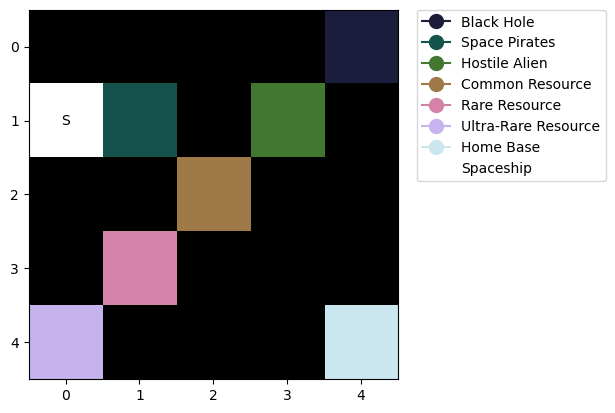


Step: 7
State: 5
Action: 3
Reward: 0
Current grid:


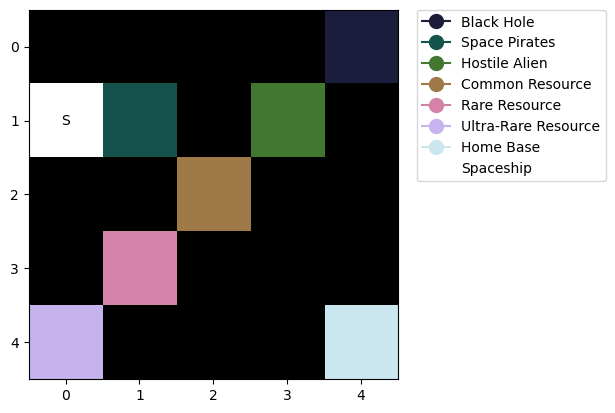


Step: 8
State: 10
Action: 1
Reward: 0
Current grid:


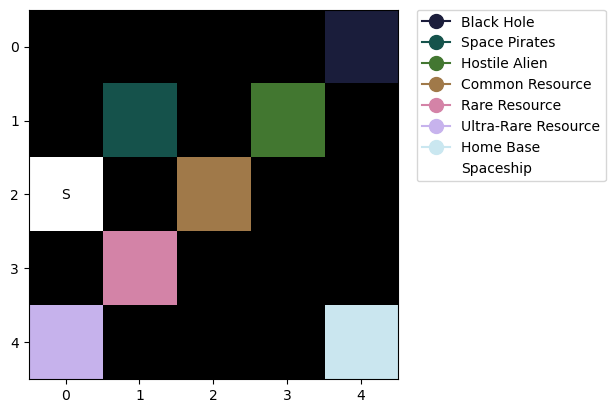


Step: 9
State: 15
Action: 1
Reward: 0
Current grid:


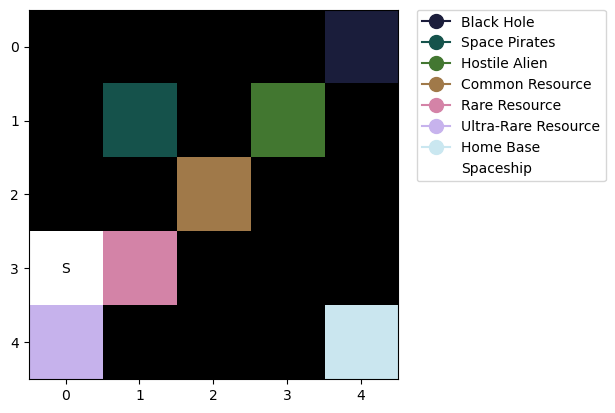


Step: 10
State: 20
Action: 1
Reward: 15
Current grid:


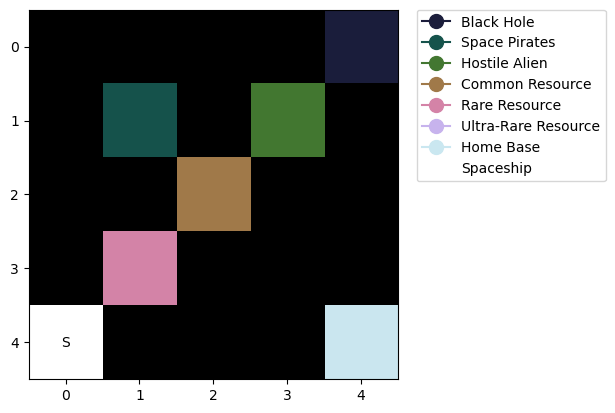


Step: 11
State: 20
Action: 1
Reward: 15
Current grid:


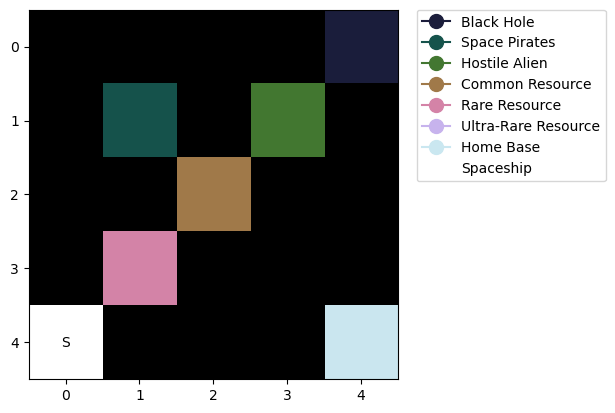


Step: 12
State: 15
Action: 0
Reward: 0
Current grid:


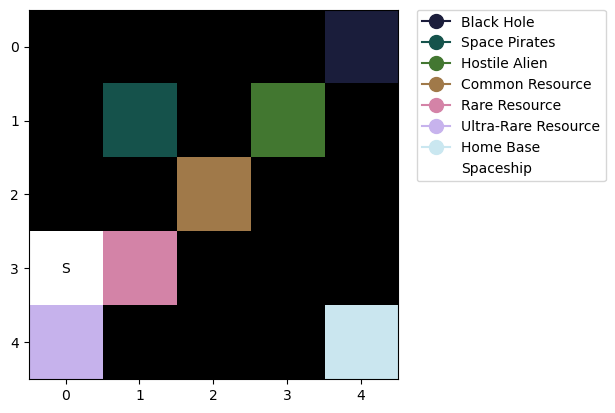

In [3]:
env = IntergalacticPlanetExplorer()
env.render()
for t in range(12):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    
    print(f"Step: {t+1}")
    print(f"State: {state}")
    print(f"Action: {action}")
    print(f"Reward: {reward}")
    print(f"Current grid:")
    env.render()
    print()

    if done:
        env.reset()
        print("Reached the goal! Resetting the environment.\n")

In [4]:
def sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, epsilon_decay, max_timesteps):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))

        action = choose_action(q_table, state, epsilon, env.action_space.n)

        for timestep in range(max_timesteps):
            next_state, reward, done, _ = env.step(action)
            next_action = choose_action(q_table, next_state, epsilon, env.action_space.n)

            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * q_table[next_state, next_action] - q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                break


        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode

def choose_action(q_table, state, epsilon, n_actions):
    if np.random.random() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(q_table[state])

def plot_rewards(rewards, title):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.show()

In [7]:
def objective(trial):
    env = IntergalacticPlanetExplorer()

    num_episodes = 500
    max_timesteps = 200

    alpha = trial.suggest_uniform('alpha', 0.01, 1.0)
    gamma = trial.suggest_uniform('gamma', 0.01, 1.0)
    epsilon_start = trial.suggest_uniform('epsilon_start', 0.01, 1.0)
    epsilon_min = trial.suggest_uniform('epsilon_min', 0.01, epsilon_start)
    epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.01, 1.0)

    _, rewards_per_episode = sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, epsilon_decay, max_timesteps)

    # Objective is to maximize the total reward, so we return the negative mean of the last 10 rewards
    return -np.mean(rewards_per_episode[-10:])

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-05-11 16:50:18,780] A new study created in memory with name: no-name-ffa33bd1-c685-4915-8d27-57f4f4ffddba
C:\Users\karti\AppData\Local\Temp\ipykernel_22608\3525157044.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform('alpha', 0.01, 1.0)
C:\Users\karti\AppData\Local\Temp\ipykernel_22608\3525157044.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 1.0)
C:\Users\karti\AppData\Local\Temp\ipykernel_22608\3525157044.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Best trial:
 Value:  2943.0
 Params: 
    alpha: 0.889750045021609
    gamma: 0.29729141769862955
    epsilon_start: 0.01411636082756973
    epsilon_min: 0.010191269589300984
    epsilon_decay: 0.10078687664406913


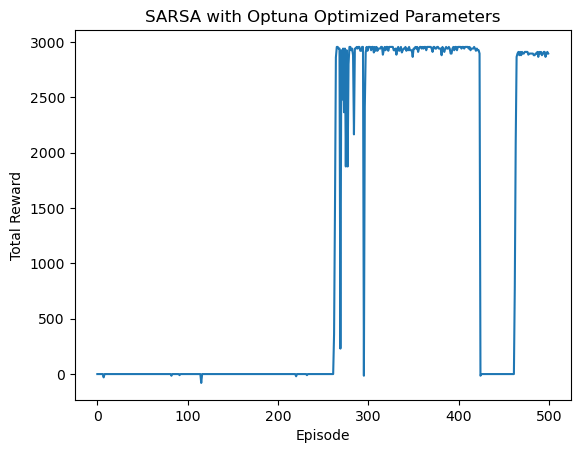

In [12]:
# Run SARSA with the optimal parameters
best_params = study.best_trial.params
alpha = best_params['alpha']
gamma = best_params['gamma']
epsilon_start = best_params['epsilon_start']
epsilon_min = best_params['epsilon_min']
epsilon_decay = best_params['epsilon_decay']

_, best_rewards = sarsa(env, 500, alpha, gamma, epsilon_start, epsilon_min, epsilon_decay, 200)

# Plot the rewards per episode
plot_rewards(best_rewards, "SARSA with Optuna Optimized Parameters")

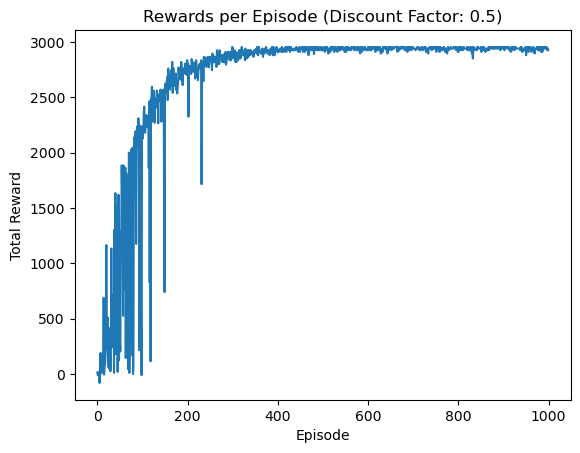

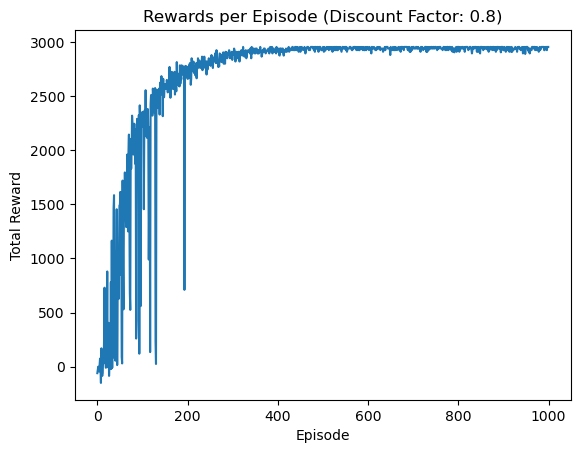

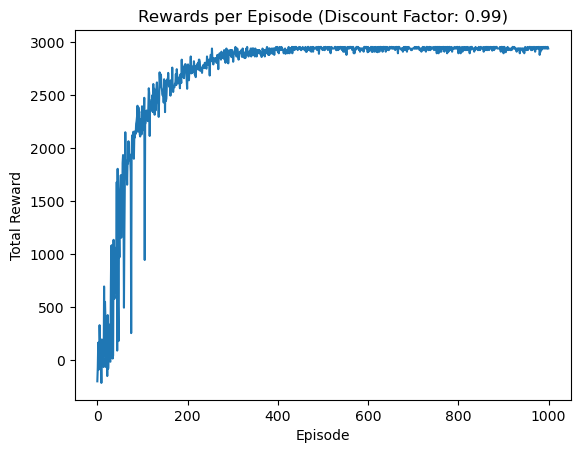

In [9]:
gammas = [0.5, 0.8, 0.99]
for gamma in gammas:
    q_table, rewards = sarsa(env, num_episodes=1000, alpha=0.1, gamma=gamma, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.99, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Discount Factor: {gamma})")

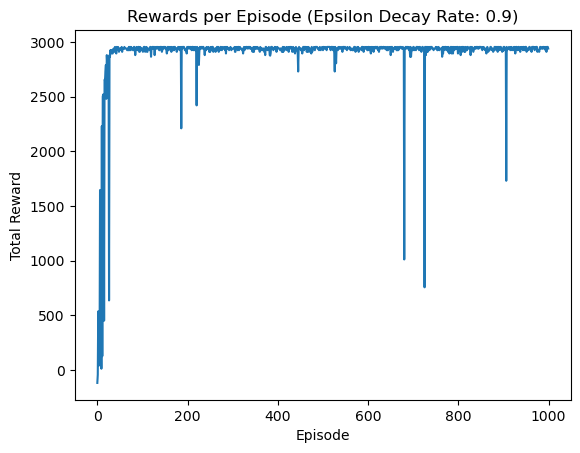

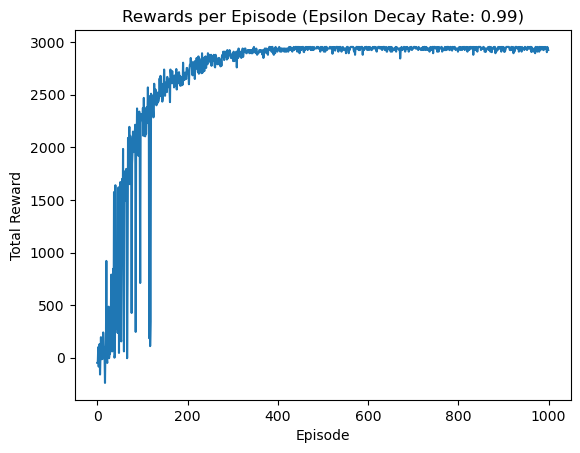

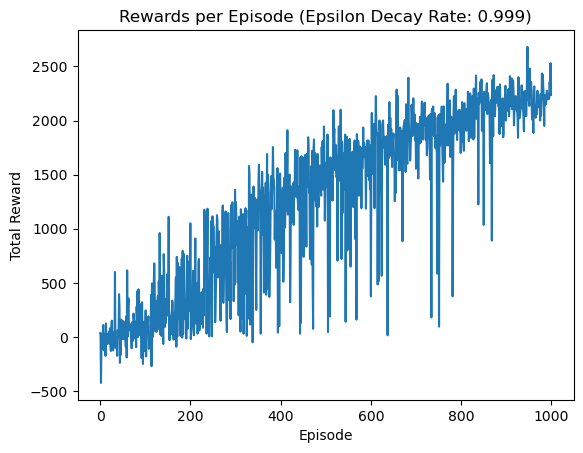

In [23]:
decay_rates = [0.9, 0.99, 0.999]
for decay_rate in decay_rates:
    q_table, rewards = sarsa(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=decay_rate, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Epsilon Decay Rate: {decay_rate})")

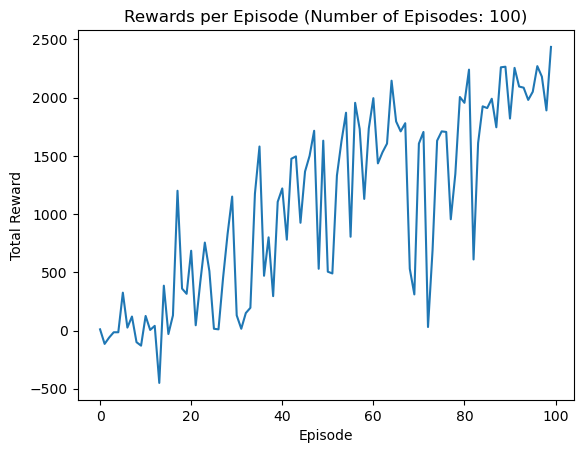

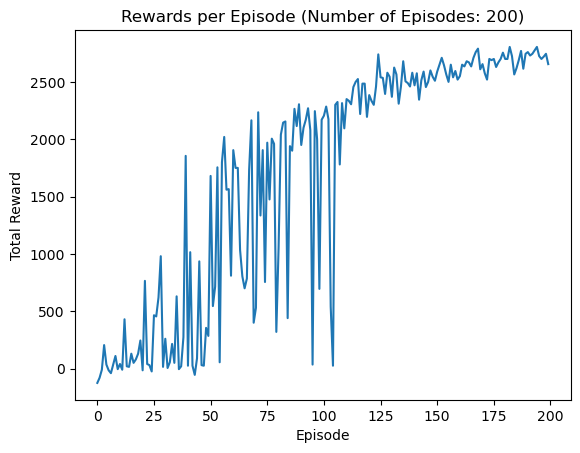

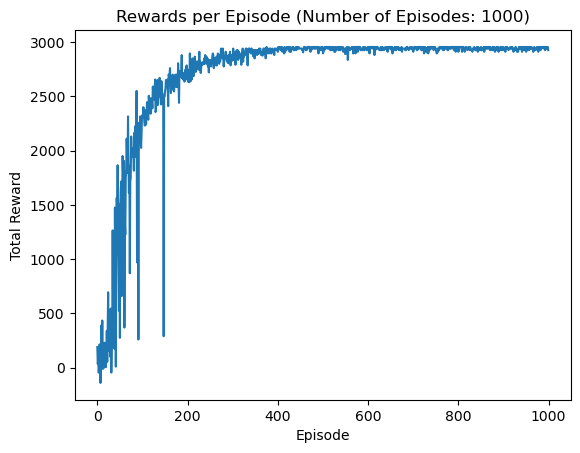

In [24]:
episode_counts = [100, 200, 1000]
for num_episodes in episode_counts:
    q_table, rewards = sarsa(env, num_episodes=num_episodes, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.99, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Number of Episodes: {num_episodes})")

In [25]:
def plot_epsilon_decay(epsilon_start, epsilon_min, epsilon_decay, num_episodes, title):
    epsilons = [max(epsilon_min, epsilon_start * (epsilon_decay ** i)) for i in range(num_episodes)]
    plt.plot(epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(title)
    plt.show()

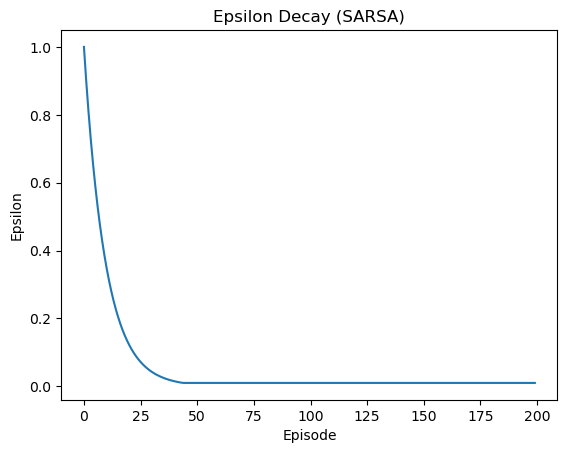

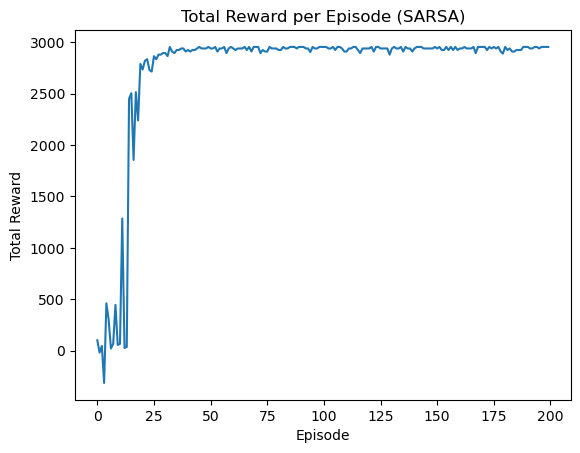

In [26]:
#Worked Best
q_table_sarsa, Srewards = sarsa(env, num_episodes=200, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9, max_timesteps=200)
plot_epsilon_decay(epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9, num_episodes=200, title="Epsilon Decay (SARSA)")
plot_rewards(Srewards, "Total Reward per Episode (SARSA)")

In [27]:
def q_learning(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, epsilon_decay, max_timesteps):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))

        for timestep in range(max_timesteps):
            action = choose_action(q_table, state, epsilon, env.action_space.n)
            next_state, reward, done, _ = env.step(action)

            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            state = next_state
            total_reward += reward

            if done:
                break


        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode

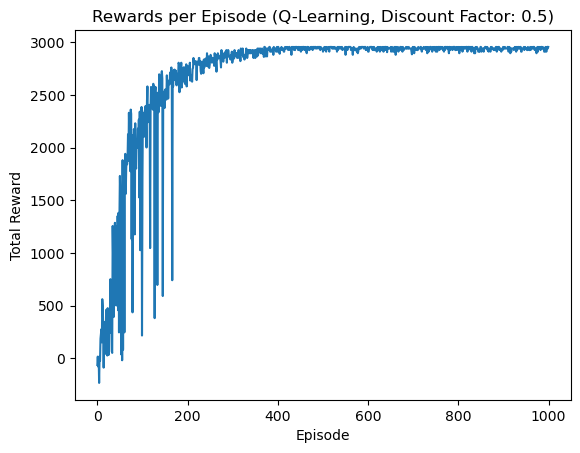

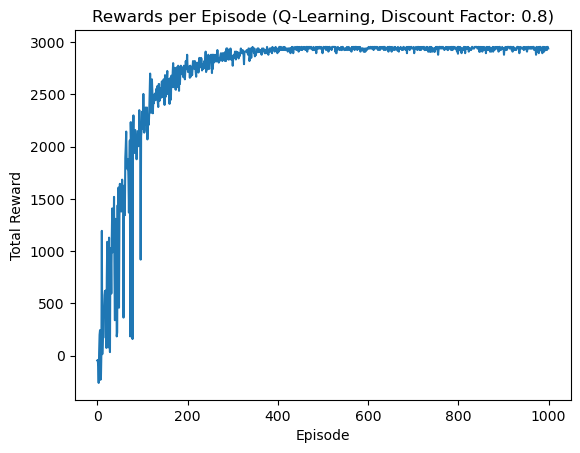

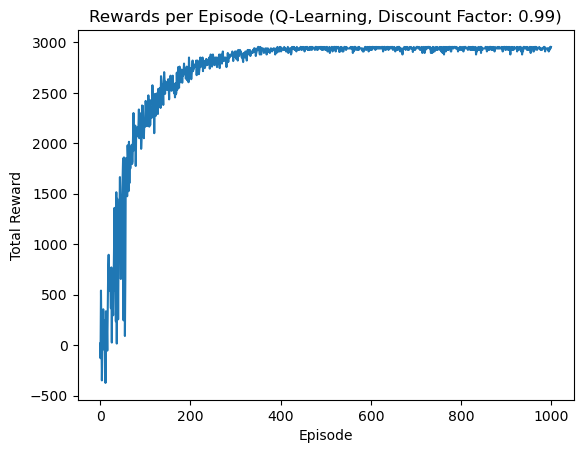

In [28]:
gammas = [0.5, 0.8, 0.99]
for gamma in gammas:
    q_table, rewards = q_learning(env, num_episodes=1000, alpha=0.1, gamma=gamma, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.99, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Q-Learning, Discount Factor: {gamma})")

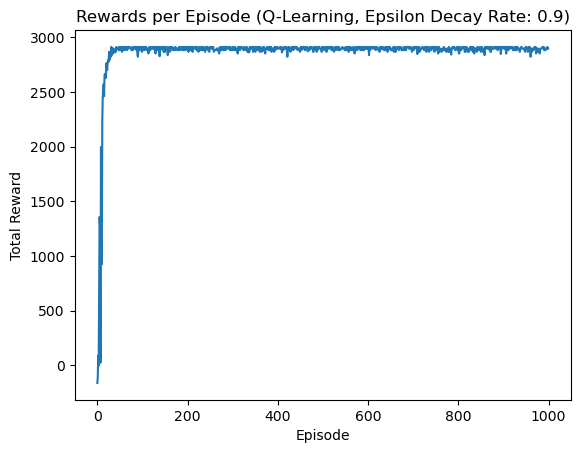

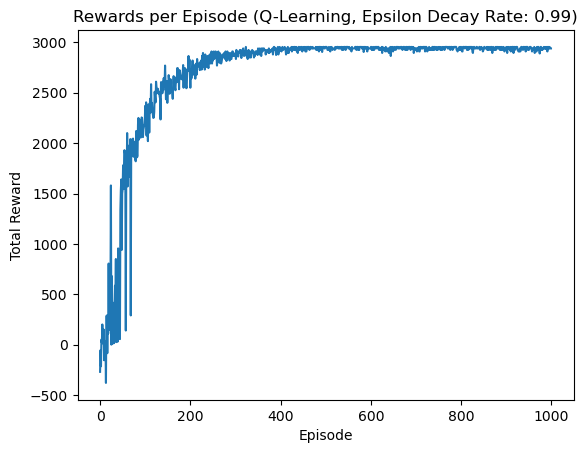

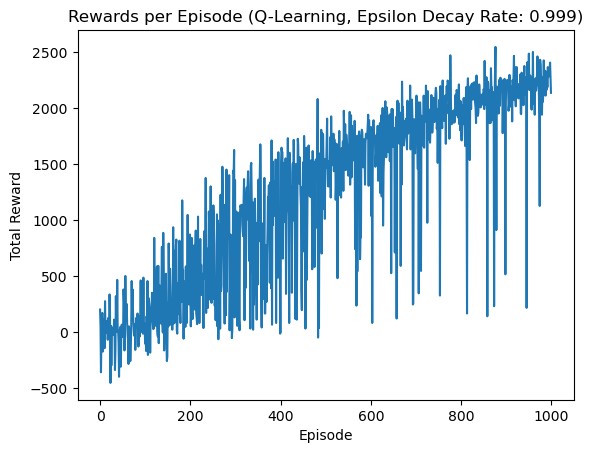

In [29]:
decay_rates = [0.9, 0.99, 0.999]
for decay_rate in decay_rates:
    q_table, rewards = q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=decay_rate, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Q-Learning, Epsilon Decay Rate: {decay_rate})")

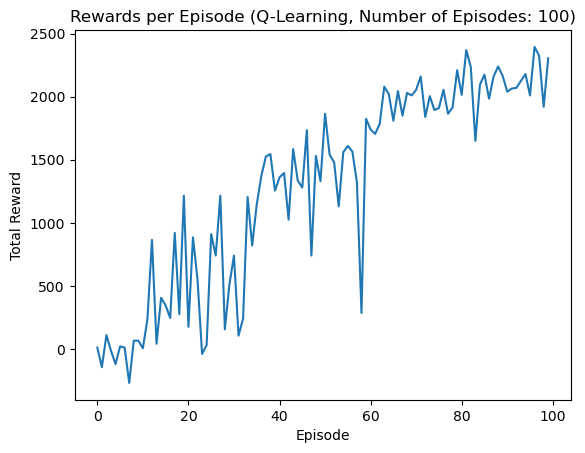

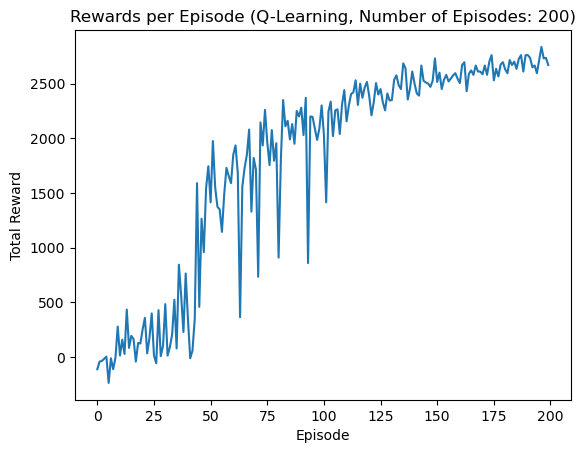

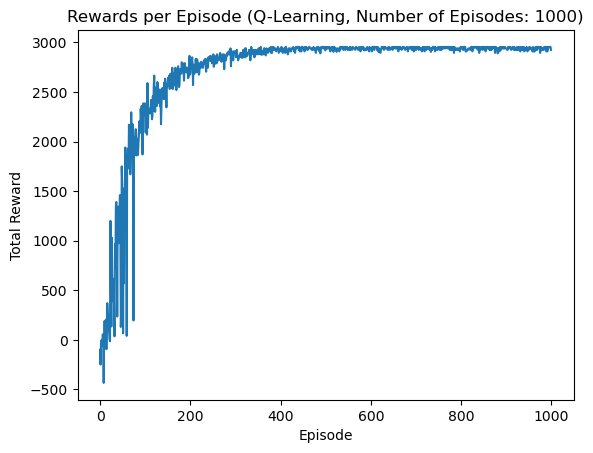

In [30]:
episode_counts = [100, 200, 1000]
for num_episodes in episode_counts:
    q_table, rewards = q_learning(env, num_episodes=num_episodes, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.99, max_timesteps=200)
    plot_rewards(rewards, f"Rewards per Episode (Q-Learning, Number of Episodes: {num_episodes})")

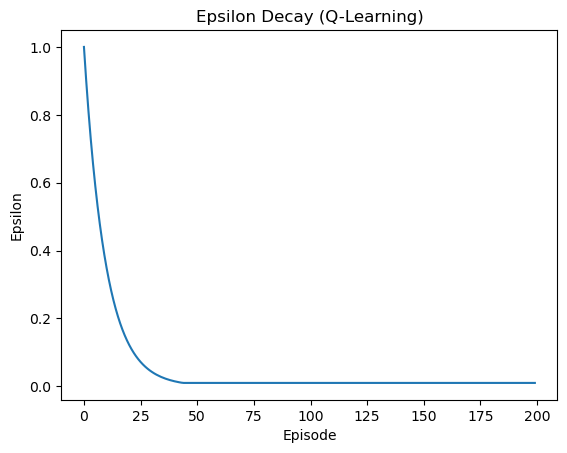

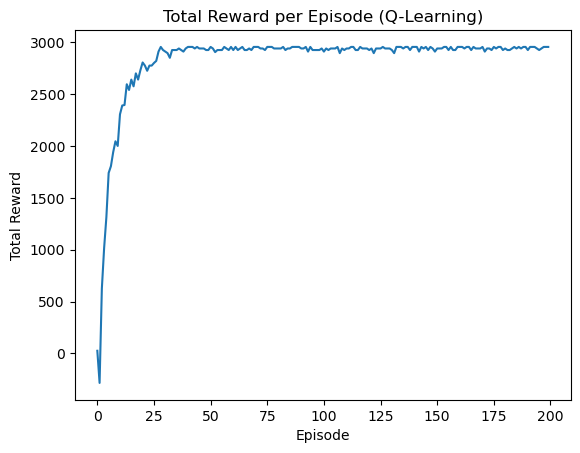

In [31]:
#Worked Best
q_table_q_learning, Qrewards = q_learning(env, num_episodes=200, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9, max_timesteps=200)
plot_epsilon_decay(epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9, num_episodes=200, title="Epsilon Decay (Q-Learning)")
plot_rewards(Qrewards, "Total Reward per Episode (Q-Learning)")

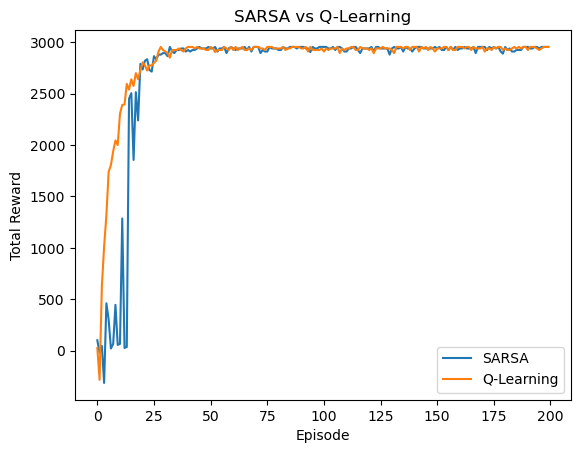

In [32]:
# Plotting the rewards per episode for both SARSA and Q-learning
plt.plot(Srewards, label="SARSA")
plt.plot(Qrewards, label="Q-Learning")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA vs Q-Learning")
plt.legend()
plt.show()

In [33]:
def two_step_sarsa(env, num_episodes, alpha, gamma, epsilon_start, epsilon_min, epsilon_decay, max_timesteps):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))

        action = choose_action(q_table, state, epsilon, env.action_space.n)

        for timestep in range(max_timesteps):
            next_state, reward, done, _ = env.step(action)
            next_action = choose_action(q_table, next_state, epsilon, env.action_space.n)

            if done:
                q_table[state, action] += alpha * (reward - q_table[state, action])
                break

            next_next_state, next_reward, done, _ = env.step(next_action)
            next_next_action = choose_action(q_table, next_next_state, epsilon, env.action_space.n)

            q_table[state, action] += alpha * (reward + gamma * q_table[next_state, next_action] + gamma**2 * next_reward * (1 - done) - q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode

def plot2_rewards(rewards_list, labels, title):
    for rewards, label in zip(rewards_list, labels):
        plt.plot(rewards, label=label)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.legend()
    plt.show()

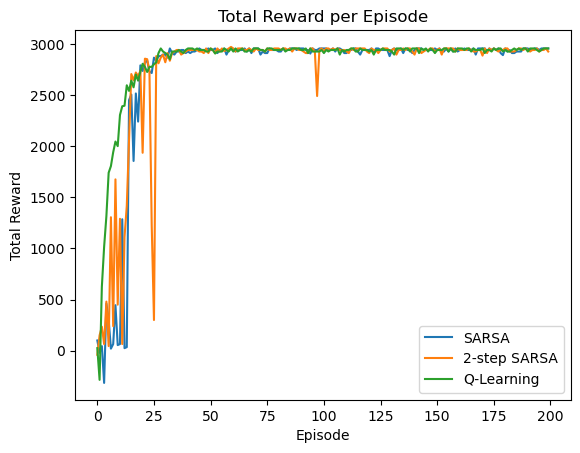

In [34]:
q_table_two_step_sarsa, TSrewards = two_step_sarsa(env, num_episodes=200, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.9, max_timesteps=200)
plot2_rewards([Srewards, TSrewards, Qrewards], ["SARSA", "2-step SARSA","Q-Learning"], "Total Reward per Episode")